In [1]:
import os
import sys
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess as subp
import glob

from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.cluster import KMeans

%matplotlib inline


In [2]:
import aztools as az
az.misc.set_fancy_plot(plt)

In [3]:
wdir = '/home/abzoghbi/data/nicerBg/reAnalysis'
os.chdir(wdir)

#### Select observations from the master catalog

In [4]:
obsDataFile = 'obsData.csv'
os.chdir(wdir)
if not os.path.exists(f'data/{obsDataFile}'):

    from astropy.io import ascii
    if not os.path.exists('nicermastr_bgd.tdat'):
        os.system('wget https://heasarc.gsfc.nasa.gov/FTP/nicer/data/catalog/nicermastr.tdat')
        os.system('cat nicermastr.tdat | grep BKGD_RXTE > nicermastr_bgd.tdat')
        os.system('rm nicermastr.tdat')
    cat = ascii.read('nicermastr_bgd.tdat').to_pandas()
    cat = cat[cat.col1 != 'BKGD_RXTE_7']
    links = cat['col4'].str.slice(0,7).str.replace('-', '_') + '/' + cat['col6'].astype('str')

    #np.random.seed(3345)
    #sampleLinks = links.iloc[np.random.randint(0, len(links), size=50)].values

    sampleLinks = links.values
    bgdIDs = cat['col1'].str.split('_', expand=True)[2].astype(int).values

#### Download the data

In [5]:
# download the data
os.chdir(wdir)
if not os.path.exists(f'data/{obsDataFile}'):

    os.chdir(wdir)
    os.system('mkdir -p data')
    iGood = []
    for il,link in enumerate(sampleLinks):
        os.chdir(f'{wdir}/data')
        o = link.split('/')[1]
        iGood.append(True)
        if not os.path.exists(o):
            os.system(f'mkdir -p {o}')
            os.chdir(o)
            cmd = (f"wget -q -nH --no-check-certificate --no-parent --cut-dirs=6 -r -l0 -c -N -np -R 'index*'"
                   f" -erobots=off --retr-symlinks https://heasarc.gsfc.nasa.gov/FTP/nicer/data/obs/{link}/")
            ret = os.system(cmd)
            if ret != 0: 
                os.chdir('..')
                os.system(f'rm -rf {o}')
                iGood[-1] = False
        # these have problems when running nicerl2, remove them by hand
        if o in ['1012020135', '2012040214', '4012080109']:
            iGood[-1] = False
    
    obsIDs = np.array([l.split('/')[1] for l in sampleLinks])
    obsIDs, bgdIDs = obsIDs[iGood], bgdIDs[iGood]
    obsData = pd.DataFrame({'obsIDs': obsIDs, 'bgdIDs':bgdIDs})
    obsData.to_csv('obsData.csv', index=False)

else:
    os.chdir(f'{wdir}/data')
    obsData = pd.read_csv(obsDataFile)
    obsIDs = obsData.obsIDs.astype(str).values
    #bgdIDs = obsData.bgdIDs.values
    #bgdIDsU = np.unique(bgdIDs)
    # groups are bgdIDs, each split into 4 sets: 7x5=35
    grpIDs = ('b' + obsData.bgdIDs.astype(str)).str.cat(
           obsData.groupby('bgdIDs').transform(
               lambda x:x.reset_index(drop=True).index%2 + 1
           ).astype(str) , sep='.')
    
    grpIDsU = np.unique(grpIDs)

#### Process the event files with `nicerl2`

In [6]:
# We use procs to keep track of running parallel processes!
pre = 'export HEADASNOQUERY=; export HEADASPROMPT=/dev/null;'

# geomag version: 10-Aug-2021 
extraOptions = ('geomag_path=/home/abzoghbi/soft/caldb/data/gen/pcf/geomag '
                'filtcolumns=NICERV3,3C50 '
                'detlist=launch,-14,-34 min_fpm=50 '
                #'tasks=SCREEN '
               )
nProcMax, procs = 30, []
for o in obsIDs:
    if not os.path.exists(f'{o}/xti/event_cl/ni{o}_0mpu7_cl.evt'):
        cmd = f'nicerl2 {o} {extraOptions} clobber=yes > tmp_{o}.log 2>&1'
        print(o)
        p = subp.Popen(['/bin/bash', '-c', pre+cmd])
        procs.append(p)
    while len(procs) >= nProcMax:
        os.system('sleep 2')
        for p in procs:
            if not p.poll() is None:
                procs.remove(p)   
for p in procs: p.wait()

#### merge the files: Do individual `BKGD_RXTE` separately

In [7]:
os.chdir(f'{wdir}/data')
merge_cmd = '''#!/usr/bin/bash
bID=$1

nimkfmerge infiles=@mkf.$bID.list outfile=merge.$bID.mkf clobber=yes
niextract-events @ufa.$bID.list merge_ufa.$bID.evt clobber=yes
nimaketime merge.$bID.mkf merge.$bID.gti min_fpm=50
nicerclean merge_ufa.$bID.evt merge_cl.$bID.evt.tmp gtifile=merge.$bID.gti clobber=yes
nifpmsel merge_cl.$bID.evt.tmp merge_cl.$bID.evt detlist=launch,-14,-34 
ftselect merge.$bID.mkf merge_cl.$bID.mkf "gtifilter(\\"merge_cl.$bID.evt\\")" clobber=yes
'''
os.system('mkdir -p merged')
os.chdir('merged')
with open('merge_cmd', 'w') as fp: fp.write(merge_cmd)
_ = os.system('chmod +x merge_cmd')

In [8]:
pre = 'export HEADASNOQUERY=; export HEADASPROMPT=/dev/null;'
procs, nProcMax = [], 35
exists = os.path.exists
for k,g in obsData.groupby(grpIDs):
    if not exists(f'merge_cl.{k}.evt') or not exists(f'merge_cl.{k}.mkf'):
        g = g.sort_values('obsIDs')
        mkf = '\n'.join([f'../{o}/auxil/ni{o}.mkf' for o in g.obsIDs])
        ufa = '\n'.join([f'../{o}/xti/event_cl/ni{o}_0mpu7_ufa.evt' for o in g.obsIDs])

        with open(f'mkf.{k}.list', 'w') as fp: fp.write(mkf+'\n')
        with open(f'ufa.{k}.list', 'w') as fp: fp.write(ufa+'\n')
        p = subp.Popen(['/usr/bin/bash', '-c', pre + f'./merge_cmd {k} > tmp_merge_cmd.{k}.log 2>&1'])
        procs.append(p)
    while len(procs) >= nProcMax:
        os.system('sleep 2')
        for p in procs:
            if not p.poll() is None:
                procs.remove(p)
for p in procs: p.wait()

---
### Preprocessing and Cleaning the data
The modeling steps are the following:
- Extract a light curve from every background region for every energy bin.
- Bin the mkf file to match produced light curve
- The data to be modeled is the count rate (from the event light curve in energy bands of interest) versus the mkf parameters at the individual time bins.

In [9]:
## INPUT ##
tBin = 1
fresh = False
eBins = [0.2, 0.4, 15]
nGrp = 50
xselectBugOffset = 0.0


nEn = len(eBins) - 1
KMeanSeed = 110
TestSplitSeed = 136

outDir = f'mod-200e'
print(outDir)

# NOTE that for a long list of mkfKeys, the code fcurve (heasoft-6.28/ftools/futils/tasks/fcurve/fcurve.f) 
# needs to be modified. Change the line: character(80) TO character(720) for the two lines definting 
# 'columns' and 'outcol' variables
# TO INCREASE STRING SIZE
mkfKeys = ['ROLL', 'SAT_LAT', 'SAT_LON', 'ELV', 'BR_EARTH', 'SUNSHINE', 'TIME_SINCE_SUNSET', 
           'SUN_ANGLE', 'BETA_ANGLE', 'LOCAL_TIME', 'MOON_ANGLE', 'RAM_ANGLE', 'EAST_ANGLE',
           'ANG_DIST', 'SAA', 'SAA_TIME', 'COR_ASCA', 'COR_SAX', 'MCILWAIN_L', 'MAGFIELD',
           'MAGFIELD_MIN', 'MAG_ANGLE', 'AP8MIN', 'AE8MIN', 'ATT_ANG_AZ', 'ATT_ANG_EL', 
           'FPM_RATIO_REJ_COUNT', 'FPM_XRAY_PI_1500_1700','FPM_XRAY_PI_1200_1500', 
           'FPM_OVERONLY_COUNT', 'FPM_UNDERONLY_COUNT', 'FPM_DOUBLE_COUNT','FPM_FT_COUNT', 
           'FPM_NOISE25_COUNT', 'XTI_PNT_JITTER', 'KP', 'SOLARPHI', 'COR_NYM',
           'ANG_DIST_X', 'ANG_DIST_Y']
mkfCols = ','.join(mkfKeys)


## NO LONER NEEDED. It is done in nicerl2
# MPU filtering: 11, 22, 60, 20 are off all the time. We additionlly exclude 34 and 14
#mpuFilter = 'DET_ID=00:13 15:33 35:80'


mod-200e-x2


In [10]:
## Extract the light curve and bin the mkf file

os.chdir(f'{wdir}/data')
os.system(f'mkdir -p {outDir}')
pre = 'export HEADASNOQUERY=; export HEADASPROMPT=/dev/null;'

# do the processing in a function so we can parallelize things
def _genData(gID):
    """Generate lc/mkf data for gID"""
    for ie in range(nEn):
        suff = f'{gID}.e{ie+1}.t{tBin}'
        if fresh or not os.path.exists(f'{outDir}/merge_cl.{suff}.lc'):
            xsl = (f'tmp_xsl.{suff}\nread ev merged/merge_cl.{gID}.evt ./\nyes\n'
                   f'filter column "PI={eBins[ie]*100+(1 if ie else 0):g}:{eBins[ie+1]*100:g}"\n'
                   f'extr curve bins={tBin} exposure=1.0 offset=no\n'
                   f'save curve {outDir}/merge_cl.{suff}.lc\nyes\nexit\nno\n')        
            with open(f'{outDir}/tmp.{suff}.xsl', 'w') as fp: fp.write(xsl)
            subp.call(['/bin/bash', '-c', pre + (f'xselect @{outDir}/tmp.{suff}.xsl > '
                                                 f'{outDir}/tmp.{suff}.xsl.log 2>&1')])
            os.system(f'rm tmp.{suff}.xsl*')
    
    mkf  = Table(fits.open(f'merged/merge.{gID}.mkf')[1].data)[['TIME']+mkfKeys].to_pandas()
    evtLc = [Table(fits.open(f'{outDir}/merge_cl.{gID}.e{ie+1}.t{tBin}.lc')[1].data).to_pandas() 
             for ie in range(nEn)]
    for ie in range(nEn): evtLc[ie].TIME += xselectBugOffset
    ii = pd.IntervalIndex.from_arrays(evtLc[0].TIME - tBin/2, 
                                      evtLc[0].TIME + tBin/2)
    t1 = mkf.TIME
    mkf.drop(columns=['TIME'], inplace=True)
    mkfLc = mkf.groupby(pd.cut(t1, ii)).mean().reset_index(drop=True)
    mkfLc.insert(0, 'TIME', evtLc[0].TIME)
    for ie in range(nEn):
        mkfLc[f'R{ie+1}'] = evtLc[ie].RATE.astype(np.double)
    mkfLc['B'] = gID.split('.')[0][1:]
    return mkfLc

dataFile = f'{outDir}/dataLc.t{tBin}.npz'
if os.path.exists(dataFile):
    print(f'Found data file {dataFile}. Reading ...')
    saved  = np.load(dataFile, allow_pickle=True)
    dataLc = pd.DataFrame(saved['dataLc'], columns=saved['cols'])
else:
    from multiprocessing import Pool
    with Pool(35) as p:
        dataLc = p.map(_genData, grpIDsU)
    os.system(f'rm {outDir}/tmp*')
    dataLc = pd.concat(dataLc).dropna().sort_values('TIME')
    np.savez(dataFile, dataLc=dataLc, cols=dataLc.columns)
    
print('Input data shape:', dataLc.shape)
dataLc.head()

Found data file mod-200e-x2/dataLc.t1.npz. Reading ...
Input data shape: (2372641, 44)


,TIME,ROLL,SAT_LAT,SAT_LON,ELV,BR_EARTH,SUNSHINE,TIME_SINCE_SUNSET,SUN_ANGLE,BETA_ANGLE,...,FPM_NOISE25_COUNT,XTI_PNT_JITTER,KP,SOLARPHI,COR_NYM,ANG_DIST_X,ANG_DIST_Y,R1,R2,B
0,112367256.5,232.456375,37.622971,214.751862,67.261162,73.780037,1.0,0.0,90.167892,71.304161,...,3.75,49.339207,2.254263,506.84729,5.287458,27.88559,-41.48315,0.0,2.0,4
1,112367257.5,232.472702,37.582722,214.81192,67.328758,73.806206,1.0,0.0,90.169495,71.304253,...,3.634615,45.285091,2.254325,506.84726,5.295414,27.923592,-30.685768,0.0,1.0,4
2,112367258.5,232.495132,37.542442,214.871918,67.392433,73.829636,1.0,0.0,90.170227,71.304329,...,3.653846,43.114719,2.254386,506.847229,5.303387,23.122524,-33.420029,0.0,0.0,4
3,112367259.5,232.526001,37.502125,214.931839,67.456551,73.851418,1.0,0.0,90.167473,71.304382,...,3.326923,48.499973,2.254448,506.847168,5.311379,32.742336,-36.831413,0.0,1.0,4
4,112367260.5,232.552109,37.461777,214.991699,67.522514,73.877724,1.0,0.0,90.170227,71.304428,...,3.538461,40.070824,2.25451,506.847137,5.319389,24.921528,-30.737345,0.0,1.0,4


In [11]:
# # Plot the light curve
# fig,ax = plt.subplots(nEn, 1, figsize=(12,3*nEn), sharex=True, sharey=True)
# ax = ax.flatten() if isinstance(ax, np.ndarray) else [ax]
# for ie in range(nEn):
#     sns.scatterplot(x='TIME', y=f'R{ie+1}', data=dataLc, ax=ax[ie], hue='B')
#     ax[ie].set_yscale('log')
# ax[0].set_ylim([1e-2, 10000])

### Constructing a bacground model
The goal is to create a model that predicts a spectrum group, (defined by the count rate in a single or multiple energy bins), from the environment variables in the `mkf` data.

The variables, or the features, are called `X`, while the dependent variable, or the target, is called `y`

In [12]:
y = dataLc[[f'R{ie+1}' for ie in range(nEn)]].clip(1e-1, np.inf).astype(np.double)
X = dataLc.iloc[:,1:(-1-nEn)]
nCol = X.shape[1]

print('y:', y.shape, ' | X:', X.shape)
assert(nCol == len(mkfKeys))

y: (2372641, 2)  | X: (2372641, 40)


#### Plot the raw data
Let us plot what the data look like.
This may be complicated, that is why we take a data science/ML approch.

In [13]:
# # A scatter plot of the unbinned data to be modeled
# nrow = max(nCol//5, 1)
# fig,axs = plt.subplots(nrow, 5, figsize=(15,nrow*3), sharey=True)
# cols = X.columns
# axs = axs.flatten()
# for ic in range(len(cols)):
#     for ie in range(nEn):
#         sns.scatterplot(x=X[cols[ic]], y=y.iloc[:,ie], ax=axs[ic], s=3)
# axs[0].set_yscale('log')
# axs[0].set_ylim([1e-1,5000])
# plt.tight_layout()

### Spectral bins
The background modeling works by using the environment variables in the `mkf` data to predict which spectral bin(s) does the data of interest fall into.

Here, we create those spectral bins, by grouping the data into groups. We can choose the bins by hand, but it is easier to used `K-means`, particularly when more than one enegy bin is used. The `K-means` classification algorithm groups the data into the desired number of groups based on the (log of the) count rate.

In [14]:
# rBins = [0.01, 0.2, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 60, 80, 122, 300]
# rCut = pd.cut(y.iloc[:,0], rBins, labels=np.arange(nGrp))
# yy = y
# grpLab = np.array(rCut.values)

In [15]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
yy = y
yys = scaler.fit_transform(yy)

In [16]:

grpMod = KMeans(n_clusters=nGrp, random_state=KMeanSeed)
grpLab = grpMod.fit_predict(scaler.fit_transform(yy))

# sort labels
grpLab2 = np.zeros(len(grpLab), np.int32)
for i,j in enumerate(yy.R1.groupby(grpLab).count().values.argsort()[::-1]):
    grpLab2[grpLab == j] = i
grpLab = grpLab2
nGrp = len(np.unique(grpLab))

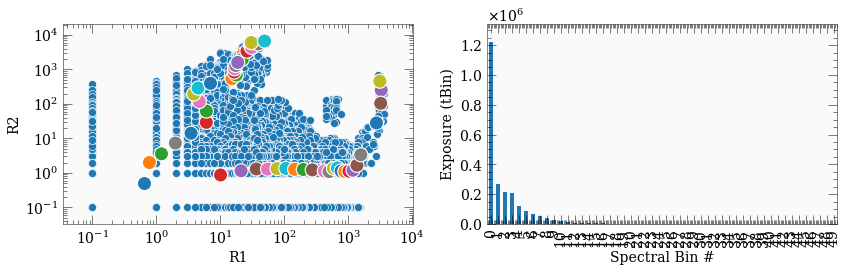

In [17]:
# plot the data groups and the number of points (exposure) in each data group
fig, ax = plt.subplots(1, 2, figsize=(12,4))

# groups
sns.scatterplot(x=yy.iloc[:,0], y=yy.iloc[:,0 if nEn==1 else 1], ax=ax[0])
ax[0].set_xscale('log'); ax[0].set_yscale('log')
#cen = yy.groupby(grpLab).mean().values[:,0]; cen = np.array([cen,cen]).T
cen = np.array([g.mean(0) for k,g in yy.groupby(grpLab)])
sns.scatterplot(x=cen[:,0], y=cen[:,1], s=200, hue=np.arange(1,nGrp+1), palette='tab10', ax=ax[0], legend=False)

# exposure
y.groupby(grpLab).R1.count().plot(kind='bar', ax=ax[1])
ax[1].set_ylabel(f'Exposure (tBin)'); _=ax[1].set_xlabel('Spectral Bin #')
plt.tight_layout()

In [18]:
y.groupby(grpLab).R1.count()

0     1217524
1      266328
2      214369
3      210197
4      122592
5       84875
6       64727
7       51526
8       43154
9       24347
10      17144
11      12215
12       6201
13       4688
14       3948
15       3925
16       3712
17       3520
18       3404
19       3317
20       2701
21       1858
22       1337
23       1235
24        953
25        778
26        569
27        315
28        312
29        199
30        120
31         98
32         69
33         57
34         57
35         45
36         43
37         31
38         25
39         25
40         23
41         23
42         16
43         11
44          8
45          6
46          5
47          4
48          3
49          2
Name: R1, dtype: int64

### Extract the base spectra

In [18]:
# extract the base spectra
os.chdir(f'{wdir}/data/{outDir}')
dTime = pd.DataFrame({'tstart':dataLc.TIME.values-tBin/2 - xselectBugOffset,
                      'tstop' :dataLc.TIME.values+tBin/2 - xselectBugOffset,})
xsl_evt = '\n'.join([f'read ev merged/merge_cl.{bID}.evt ../../\nyes\n' for bID in grpIDsU])


#for k,g in dTime.groupby(grpLab):
def _createSpec(arg):
    k,g = arg
    sfile = f'spec.{k+1}.pha'
    print(f'{sfile}:\t\t{len(g)}')
    if not os.path.exists(sfile):
        os.system(f'mkdir -p spec_{k+1}')
        os.chdir(f'spec_{k+1}')
        g.to_csv(f'rate.{k+1}.gti', sep=' ', columns=['tstart', 'tstop'], 
                        header=False, index=False)
        xsl = (f'tmp_xsl.{k+1}\n{xsl_evt}\n'
               f'filter time file rate.{k+1}.gti\n'
               f'extr spec\nsave spec {sfile}\nyes\nexit\nno\n')
        with open(f'tmp.{k+1}.xsl', 'w') as fp: fp.write(xsl)
        p = subp.call(['/bin/bash', '-c', pre + f'xselect @tmp.{k+1}.xsl > tmp.{k+1}.xsl.log 2>&1'])
        os.system(f'rm tmp.{k+1}.xsl*')
        os.system(f'mv {sfile} ..')
        os.chdir('..')
        os.system(f'rm -rf spec_{k+1}')
        os.system('sleep 0.5')

from multiprocessing import Pool
args = list(dTime.groupby(grpLab))
args = [[k,g] for k,g in args if not os.path.exists(f'{outDir}/spec.{k+1}.pha')]
with Pool(15 if len(args) else 1) as p:
    p.map(_createSpec, args)

        
os.system('ln -fs $CALDB/data/nicer/xti/cpf/arf/nixtiaveonaxis20170601v004.arf spec.arf')
os.system('ln -fs $CALDB/data/nicer/xti/cpf/rmf/nixtiref20170601v002.rmf spec.rmf')
os.chdir(f'{wdir}/data')

spec.2.pha:		266328
spec.3.pha:		214369
spec.4.pha:		210197
spec.5.pha:		122592
spec.6.pha:		84875
spec.7.pha:		64727
spec.8.pha:		51526
spec.10.pha:		24347
spec.11.pha:		17144spec.16.pha:		3925spec.12.pha:		12215spec.13.pha:		6201
spec.17.pha:		3712
spec.14.pha:		4688spec.15.pha:		3948spec.9.pha:		43154spec.18.pha:		3520





spec.19.pha:		3404spec.20.pha:		3317


spec.21.pha:		2701spec.22.pha:		1858spec.23.pha:		1337spec.24.pha:		1235



spec.25.pha:		953spec.26.pha:		778
spec.27.pha:		569spec.28.pha:		315
spec.29.pha:		312spec.30.pha:		199spec.31.pha:		120
spec.33.pha:		69
spec.34.pha:		57
spec.35.pha:		57spec.36.pha:		45

spec.32.pha:		98
spec.38.pha:		31spec.37.pha:		43
spec.39.pha:		25spec.1.pha:		1217524
spec.40.pha:		25
spec.41.pha:		23
spec.42.pha:		23

spec.43.pha:		16spec.44.pha:		11
spec.45.pha:		8

spec.46.pha:		6

spec.47.pha:		5
spec.48.pha:		4spec.49.pha:		3

spec.50.pha:		2






In [19]:
# # The following is used when the above fails for long gti's

# iSpec = 1
# os.chdir(f'{wdir}/data/{outDir}')
# os.system(f'mkdir -p spec_{iSpec}')
# os.chdir(f'spec_{iSpec}')

# for k,g in dataLc.groupby([grpLab, 'B']):
#     ispec = int(k[0]) + 1
#     bID   = k[1]
#     if ispec != iSpec: continue
    
#     dT = pd.DataFrame({'tstart':g.TIME.values-tBin/2 - xselectBugOffset,
#                        'tstop' :g.TIME.values+tBin/2 - xselectBugOffset,})
#     xsl_evt = '\n'.join([f'read ev merged/merge_cl.b{bID}.{i}.evt ../../\nyes\n' for i in [1,2]])
    

#     dT.to_csv(f'rate.{bID}.gti', sep=' ', columns=['tstart', 'tstop'], 
#                 header=False, index=False)
    
#     sfile = f'spec_{bID}.pha'
#     print(sfile)
#     xsl = (f'tmp_xsl.{bID}\n{xsl_evt}\n'
#            f'filter time file rate.{bID}.gti\n'
#            f'extr spec\nsave spec {sfile}\nyes\nexit\nno\n')
#     with open(f'tmp.{bID}.xsl', 'w') as fp: fp.write(xsl)
#     if not os.path.exists(sfile):
#         p = subp.call(['/bin/bash', '-c', pre + f'xselect @tmp.{bID}.xsl > tmp.{bID}.xsl.log 2>&1'])
    
# expr = '+'.join([f'spec_{i}.pha' for i in [1,2,3,4,5,6,8]])
# cmd = f'mathpha "{expr}" C spec.{iSpec}.pha CALC NULL 0 clobber=yes > tmp_mathpha.log 2>&1'
# subp.call(['/bin/bash', '-c', pre + cmd])
# os.system(f'mv spec.{iSpec}.pha ..')

### Modeling
Here we bin both the features and count rate according to which group they belong to.

In [20]:
#y.shape, X.shape
y1 = grpLab
X1 = X

In [21]:
# do the standard data modeling: split into train/test data
XTrain, XTest, yTrain, yTest = train_test_split(X1, y1, test_size=0.2, random_state=331)

XPreProc = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])
XTrainP = XPreProc.fit_transform(XTrain)
XTestP  = XPreProc.transform(XTest)

yPreProc = Pipeline(steps=[
    ('log', FunctionTransformer(np.log, inverse_func=np.exp, check_inverse=False)),
    ('scaler', StandardScaler())
])
yTrainP = yTrain#yPreProc.fit_transform(yTrain)
yTestP  = yTest#yPreProc.transform(yTest)


print('Train: X:', XTrainP.shape, ' | y:', yTrainP.shape)
print('Test : X:', XTestP.shape, '  | y:', yTestP.shape)

Train: X: (1898112, 40)  | y: (1898112,)
Test : X: (474529, 40)   | y: (474529,)


In [ ]:
import xgboost as xgb

param_dist = {'objective':'multi:softmax', 'num_class':nGrp, 'n_estimators':500, 
              'max_depth':4, 'eta':0.3, 'booster':'gbtree', 'nthread':30,
              'random_state':345, 'min_child_weight':4,
             }

mod = xgb.XGBModel(**param_dist)

xx = y.groupby(grpLab).R1.count()
weights = xx.sum()*0.1/xx

if os.path.exists(f'{outDir}/mod.npz'):
    mod = np.load(f'{outDir}/mod.npz', allow_pickle=True)['mod'][()]
else:
    mod.fit(XTrainP, yTrainP,
            eval_set=[(XTrainP, yTrainP), (XTestP, yTestP)],
            eval_metric='mlogloss',
            early_stopping_rounds=4,
            #sample_weight=weights[yTrainP].values,
            verbose=True)

[0]	validation_0-mlogloss:1.54747	validation_1-mlogloss:1.55031
[1]	validation_0-mlogloss:1.25096	validation_1-mlogloss:1.25306
[2]	validation_0-mlogloss:1.16619	validation_1-mlogloss:1.16869


In [30]:
mod.best_score

0.769871

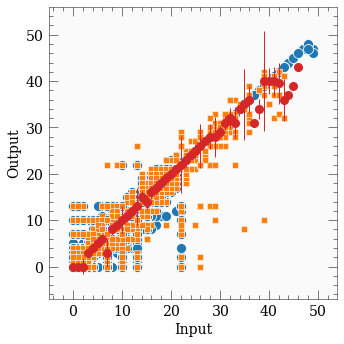

In [31]:
# plot the predictions of the model
pTrain = mod.predict(XTrainP)
pTest  = mod.predict(XTestP)

fig,ax = plt.subplots(1, 1, figsize=(5,5), sharey=True)
sns.scatterplot(x=yTrainP, y=pTrain, s=100, ax=ax)
sns.scatterplot(x=yTestP, y=pTest, s=40, ax=ax, marker='s')
ax.set_xlabel('Input'); ax.set_ylabel('Output')

if len(yTestP) != len(np.unique(yTestP)):
    xx = pd.DataFrame({'pred':pTest, 'y':yTestP}).groupby(yTestP).agg(['median', 'std'])
    ax.errorbar(xx.y['median'], xx.pred['median'], xx.pred['std'], 
                fmt='o', color='C3', ms=8)
plt.tight_layout()

### Extract background for a given `obsID`

In [ ]:
os.chdir(f'{wdir}/data')
if not os.path.exists(f'{outDir}/mod.npz'):
    np.savez(f'{outDir}/mod.npz', mod=mod, tBin=tBin, nGrp=nGrp, mkfCols=mkfCols, XPreProc=XPreProc)

In [ ]:
# feature importance
feature_importance = mod.feature_importances_
isort = np.argsort(feature_importance)[::-1]
fig = plt.figure(figsize=(12,6))
sns.lineplot(x=X.columns[isort], y=feature_importance[isort], drawstyle='steps-mid')
_ = plt.xticks(rotation=90)
plt.ylabel('Feature Importance')
#plt.savefig(f'{outDir}/plot_importance.png', bbox_inches='tight')

### Energy-dependent residuals

In [ ]:

def extract_bgd_spec_resid(obsID, do3C50=True, log=True, enBins=None):
    
    if enBins is None: enBins = eBins
    
    os.chdir(f'{wdir}/data/{obsID}')
    os.system('mkdir -p spec')
    os.chdir('spec')

    ## first, extract spectrum if needed
    if not os.path.exists('spec.pha'):
        xsl = (f'tmp_xsl_\nread ev ../xti/event_cl/ni{obsID}_0mpu7_cl.evt ./\nyes\n'
               f'extr spec\nsave spec spec.pha\nexit\nno\n')
        with open('tmp.xsl', 'w') as fp: fp.write(xsl)
        cmd = 'xselect @tmp.xsl > tmp.xsl.log 2>&1'
        subp.call(['/bin/bash', '-c', pre + cmd])

    ## also, extract the 3c50 background
    if do3C50 and not os.path.exists(f'spec.3c50.bgd'):
        cmd = (f'nibackgen3C50 rootdir=../.. obsid={obsID} bkgidxdir=$HEADAS/../nicer/tasks/bg_models_3C50'
               ' bkglibdir=$HEADAS/../nicer/tasks/bg_models_3C50 gainepoch=2020 >tmp_bgd.log 2>&1')
        subp.call(['/bin/bash', '-c', pre + cmd])
        os.system(f'mv nibackgen3C50_bkg.pi spec.3c50.bgd')


    # bin the mkf file
    suff = f't{tBin}'
    if not os.path.exists(f'ni.{suff}.mkf'):
        #cmd = (f'geomagterp ../auxil/ni{obsID}.mkf INFILE $CALDB/data/gen/pcf/geomag/kp_noaa.fits')
        #subp.call(['/bin/bash', '-c', pre + cmd])
        
        cmd = (f'fcurve infile=../auxil/ni{obsID}.mkf '
               f'gtifile=../xti/event_cl/ni{obsID}_0mpu7_cl.evt[GTI] '
               f'outfile=ni.{suff}.mkf.tmp timecol=TIME columns="{mkfCols}" '
               f'binsz={tBin*1.0} lowval=INDEF highval=INDEF binmode=Mean '
               f'outerr=NONE outlive=FRACEXP clobber=yes  > tmp.fcurve.{suff}.log 2>&1')
        subp.call(['/bin/bash', '-c', pre + cmd])
        cmd = (f'fselect ni.{suff}.mkf.tmp ni.{suff}.mkf "FRACEXP>0" clobber=yes')
        subp.call(['/bin/bash', '-c', pre + cmd])
        os.system(f'rm ni.{suff}.mkf.tmp')

    # read the mkf data
    mkfLcB = Table(fits.open(f'ni.{suff}.mkf')[1].data).to_pandas()
    if mkfLcB.shape[0] == 0:
        if log: print('There are no data!')
        return


    # apply the model pre-processing to this obsID
    #XB = XPreProc.transform(mkfLcB.iloc[:,1:-1])
    XB = XPreProc.transform(mkfLcB.loc[:,mkfKeys])
    

    # model prediction #
    yPred = mod.predict(XB)

    # cluster prediction
    #if nEn == 1:
    #    yPred = np.c_[yPred, yPred]
    #gPred = grpMod.predict(yPred).astype(int)
    gPred = yPred.astype(int)
    weights = pd.DataFrame({'weight':gPred+1}).groupby('weight').apply(len)/len(gPred)
    weights = weights[weights > 0]
    if log: print(weights)

    # create weighted background file #
    os.chdir(f'{wdir}/data/{outDir}')
    expr = '+'.join([f'{x:4.4}*spec.{i}.pha' for i,x in weights.items()])
    cmd = f'mathpha "{expr}" R spec.b.pha CALC NULL 0 clobber=yes > tmp_mathpha.log 2>&1'
    subp.call(['/bin/bash', '-c', pre + cmd])

    # add headers to spectral file
    os.system(f'cp {wdir}/data/{obsID}/spec/spec.pha .')
    os.system(f'cp {wdir}/data/{obsID}/spec/spec.3c50.bgd .')
    os.system(f'cp spec.b.pha {wdir}/data/{obsID}/spec/')
    
    
    cmd = (f'grppha spec.pha !tmp.pha "chkey respfile spec.rmf&'
           f'chkey ancrfile spec.arf&chkey backfile spec.b.pha&exit" > tmp_grppha.log 2>&1')
    subp.call(['/bin/bash', '-c', pre + cmd])
    os.system(f'mv tmp.pha spec.pha')
    
    
    
    os.system(f'cp spec.b.pha {wdir}/data/{obsID}/spec/')
    
    
    # get rate
    xs = (f'da spec.pha\nign 0.0-{enBins[0]:.1f},{enBins[-1]:.1f}-**\n'
          'setpl chan\nputs [tcloutr plot da x]\n'
          'puts [tcloutr plot da y]; puts [tcloutr plot da yerr]\n')
    if do3C50:
        xs += 'back spec.3c50.bgd\nputs [tcloutr plot da y]; puts [tcloutr plot da yerr]\n'
    xs += 'exit'
    with open('tmp_xs.xcm', 'w') as fp: fp.write(xs)
    subp.call(['/bin/bash', '-c', 'xspec - tmp_xs.xcm > tmp_xs.log 2>&1'])
    
    ye = np.array(open('tmp_xs.log').readlines()[-6].split(), np.double)
    y  = np.array(open('tmp_xs.log').readlines()[-11].split(), np.double)
    if do3C50:
        y_3c, ye_3c = y, ye
        ye = np.array(open('tmp_xs.log').readlines()[-21].split(), np.double)
        y  = np.array(open('tmp_xs.log').readlines()[-26].split(), np.double)
        en = np.array(open('tmp_xs.log').readlines()[-31].split(), np.double)
        resid = np.array([en, y, ye, y_3c, ye_3c])
    else:
        en = np.array(open('tmp_xs.log').readlines()[-16].split(), np.double)
        resid = np.array([en, y, ye])

    os.chdir(f'{wdir}/data')
    return resid


    

In [ ]:
#r = extract_bgd_spec_resid('3012010114', do3C50=True)

In [ ]:
os.chdir(f'{wdir}/data')
residFile = f'{outDir}/resid_resutls.npz'
if os.path.exists(residFile):
    r = np.load(residFile, allow_pickle=True)
    Resid = r['Resid'][()]
else:
    Resid = {}
len(Resid)

In [ ]:
os.chdir(f'{wdir}/data')
#Resid = {}
for o in obsIDs:#[np.random.randint(0, len(obsIDs), size=50)]:
    if o in Resid.keys(): continue
    try:
        r = extract_bgd_spec_resid(o, do3C50=True, log=False)
    except FileNotFoundError:
        r = None
    if r is None:
        print(o, r)
    else:
        print(o, r[1].sum(), r[3].sum())
    Resid[o] = r

In [33]:
os.chdir(f'{wdir}/data')
residFile = f'{outDir}/resid_resutls.npz'
np.savez(residFile, Resid = Resid)

In [32]:
Rs  = np.array([x for x in Resid.values() if not x is None and len(x)])
R = np.c_[Rs[:,1].sum(-1), (Rs[:,2]**2).sum(-1)**0.5, 
          Rs[:,3].sum(-1), (Rs[:,4]**2).sum(-1)**0.5]
Rso = np.array([x for x in Resid.keys() if not Resid[x] is None and len(x)])
en = Rs[0,0]
Rs.shape, R.shape

((1358, 5, 1479), (1358, 4))

(-5.0, 100.0)

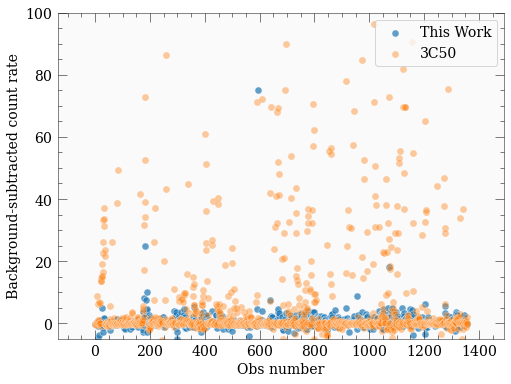

In [34]:
fig = plt.figure(figsize=(8,6))
sns.scatterplot(x=np.arange(len(R)), y=R[:,0], label='This Work', alpha=0.7, s=50)
sns.scatterplot(x=np.arange(len(R)), y=R[:,2], label='3C50', alpha=0.4, s=50)
plt.xlabel('Obs number')
plt.ylabel('Background-subtracted count rate')
plt.legend()
plt.ylim([-5,100])
#plt.yscale('log')
#plt.savefig(f'{outDir}/plot_rate_vs_3c50.png')

    0.9   0.288   0.714     3.7    9.75
   0.99   0.358    1.12    10.2    45.9
    1.0   0.388    1.51    13.6    72.7


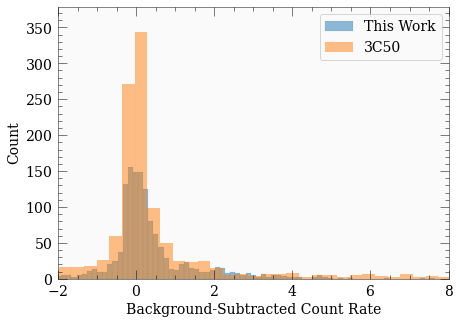

In [35]:
for iq,q in enumerate([0.9, 0.99, 1.0]):
    x = np.array(R[:,0])
    x = x[(x<np.quantile(x, 0.5+q/2)) & (x>np.quantile(x, 0.5-q/2))]
    xc = np.array(R[:,2])
    xc = xc[(xc<np.quantile(xc, 0.5+q/2)) & (xc>np.quantile(xc, 0.5-q/2))]
    print(f'{q:7.3} {x.mean():7.3} {x.std():7.3} {xc.mean():7.3} {xc.std():7.3}')
plt.figure(figsize=(7,5))
sns.histplot(np.array(R[:,0]), alpha=0.5, label='This Work')
sns.histplot(np.array(R[:,2]), alpha=0.5, color='C1', label='3C50')
plt.xlim([-2,8])
plt.xlabel('Background-Subtracted Count Rate')
plt.legend()
#plt.savefig(f'{outDir}/plot_hist_vs_3c50.png')

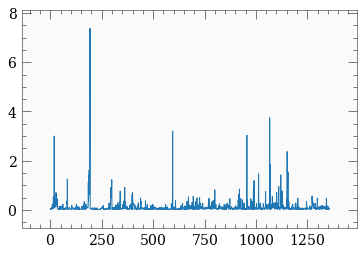

In [36]:
plt.plot(R[:,1])

In [37]:
# remove low exposure obsids
#snr = np.abs(Rs[:,1]/Rs[:,2]).mean(1)
iGood = R[:,1] < 0.5
R, Rs, Rso = R[iGood], Rs[iGood], Rso[iGood]
Rs.shape, R.shape

((1315, 5, 1479), (1315, 4))

In [38]:
Rs_d = pd.DataFrame(np.r_[Rs[:,1], Rs[:,3]])
Rs_d.columns = Rs[0,0].astype(int)
Rs_d['mod'] = ['ML']*Rs.shape[0] + ['3C50']*Rs.shape[0]
#Rs_d['Rs'] = np.r_[R[:,1], R[:,3]]
rbins = [0,0.99,1]
RsCut = np.r_[pd.qcut(R[:,3], rbins, labels=['99%','1%']), 
              pd.qcut(R[:,3], rbins, labels=['99%','1%'])]

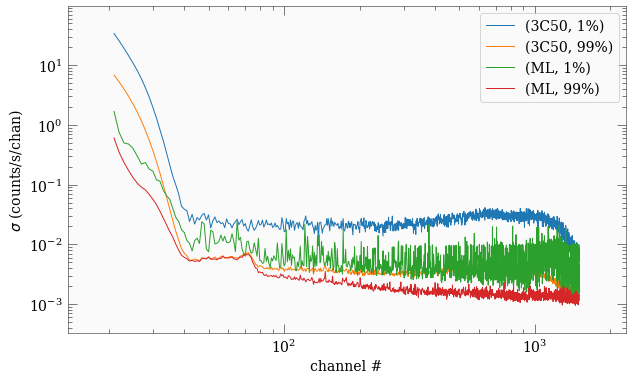

In [39]:

#Rs_d.groupby('mod').std().T.plot(figsize=(9,7))
ax = Rs_d.groupby(['mod', RsCut]).std().T.plot(figsize=(10,6))
plt.xscale('log')
plt.ylabel(r'$\sigma$ (counts/s/chan)')
plt.legend(loc='upper right')
plt.xlabel('channel #')
plt.yscale('log')
#plt.savefig(f'{outDir}/plot_energy_dep_performance.png')

In [40]:
for q in [0.9,0.99,1.]:
    x = np.array(R[:,0])
    x = x[(x<np.quantile(x, 0.5+q/2)) & (x>np.quantile(x, 0.5-q/2))]
    xc = np.array(R[:,2])
    xc = xc[(xc<np.quantile(xc, 0.5+q/2)) & (xc>np.quantile(xc, 0.5-q/2))]
    print(f'{q:7.3} {x.mean():7.3} {x.std():7.3} {xc.mean():7.3} {xc.std():7.3}')

    0.9   0.261   0.655    2.62    7.34
   0.99   0.317   0.989    4.91    15.5
    1.0   0.327    1.09     5.9    25.4


(-0.5, 0.5)

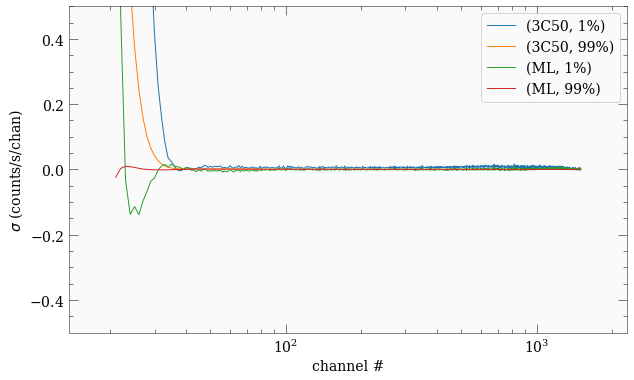

In [41]:

#Rs_d.groupby('mod').std().T.plot(figsize=(9,7))
ax = Rs_d.groupby(['mod', RsCut]).mean().T.plot(figsize=(10,6))
plt.xscale('log')
plt.ylabel(r'$\sigma$ (counts/s/chan)')
plt.legend(loc='upper right')
plt.xlabel('channel #')
#plt.yscale('log')
#plt.savefig(f'{outDir}/plot_energy_dep_performance.png')
plt.ylim([-0.5,0.5])